<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/Two_finger_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mar 14.25.F
from scipy.io import loadmat

file_name = 'MonkeyN_KC' # MonkeyN_MC, MonkeyN_RC, MonkeyW_MC, MonkeyW_RC
file_path = f'/content/drive/MyDrive/ML Projects/Two Finger Neural Decoding/Data/{file_name}.mat'

mat_data = loadmat(file_path)
targ     = mat_data['targ']
targsize = mat_data['targsize']


In [2]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'targsize', 'X', 'targ', 'trials', 'y'])

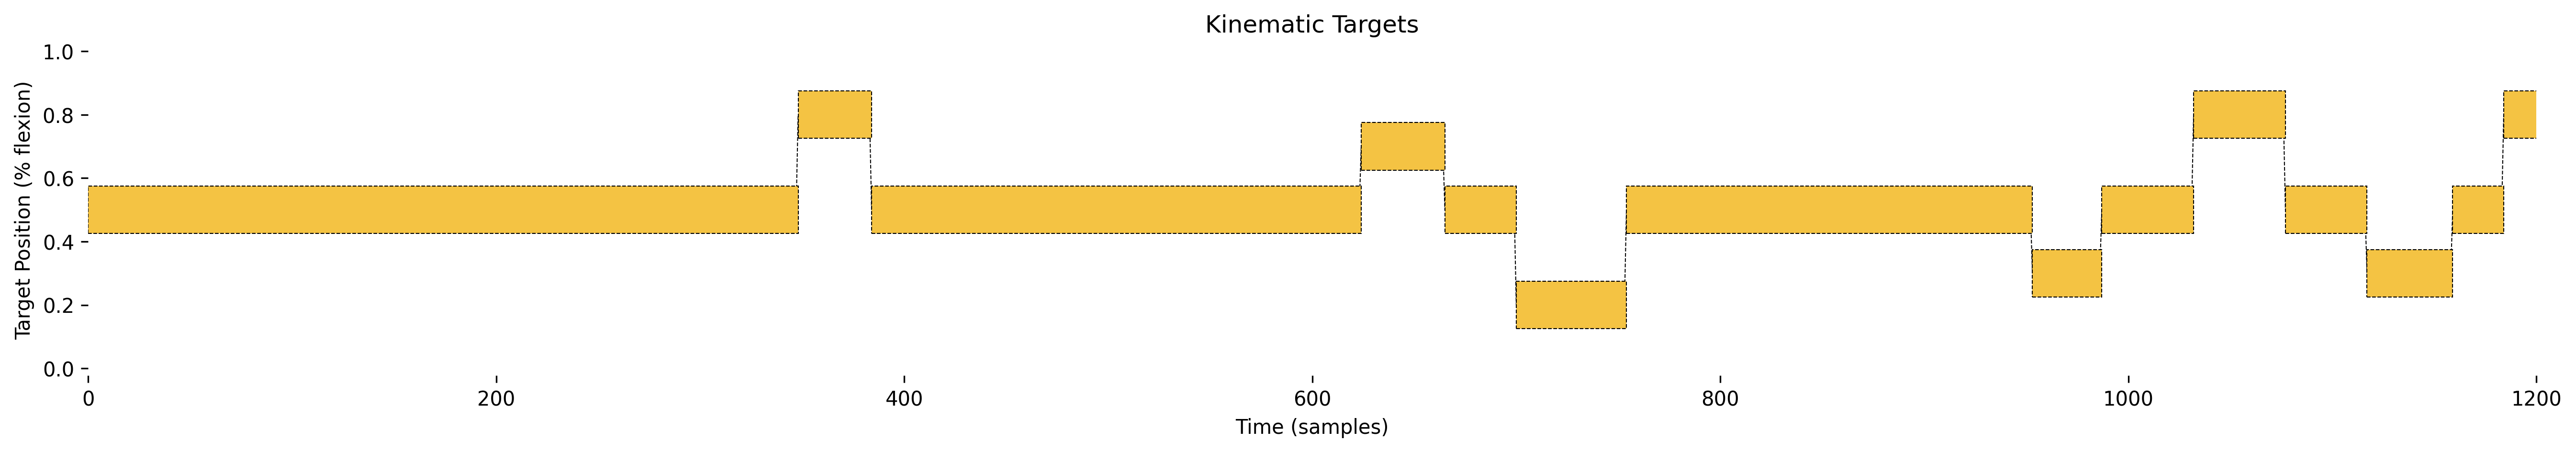

In [31]:
def plot_targets(targ, targsize, fing_color,x_lim=(0,len(targ))):

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd

  # Find transitions in target display
  targ_starts = np.concatenate(([0], np.where(np.diff(targ) != 0)[0] + 1))

  # Compute the duration (W) of each target
  targ_durations = np.diff(np.append(targ_starts, len(targ)))  # Ensuring last target is included

  # Compute target heights
  targ_half_height = targsize[targ_starts].flatten()  # Select correct column
  targ_height = 2 * targ_half_height  # Full height = 2 * R
  targ_locs = targ[targ_starts] - targ_half_height  # Compute Y positions

  # Plot the targets as rectangles
  fig, ax = plt.subplots(figsize=(22, 3), dpi=300)
  ax.plot(range(len(targ)), targ, 'k', linewidth=0.5, linestyle='--', zorder=1)  # Plot the target trajectory

  # Draw rectangles
  for i in range(len(targ_starts)):
      rect = plt.Rectangle((targ_starts[i], targ_locs[i]),
                          targ_durations[i], targ_height[i],
                          edgecolor='k', facecolor=fing_color,
                          alpha=1, linestyle='--', linewidth=0.5, zorder=2)
      ax.add_patch(rect)
  ax.spines[:].set_visible(False)

  ax.set_xlim(x_lim[0], x_lim[-1])
  # ax.set_ylim(-100, 100)
  # Configure plot
  ax.set_xlabel('Time (samples)')
  ax.set_ylabel('Target Position (% flexion)')
  ax.set_title('Kinematic Targets')
  ax.grid(False)
  plt.show()

fing = 1  # select finger to plot
fing_color = '#9CEAEF' if fing == 0 else '#F4C343' if fing == 1 else 'k'
plot_targets(targ[:, fing], targsize, fing_color, x_lim=(0,1200))
